The theme of this lab is to introduce and explain several ’easier’
quantum algorithms. These algorithms are all of historical / academic importance, although perhaps not terribly relevant for
application purposes. We shall see several threads of commonality between all algorithms, which make them a good set of algorithms to learn together.

In this lab, we will begin by briefly discussing the context for when we want to use quantum algorithms, and what makes a
quantum algorithm ’faster’. Then, we will proceed to the main topic: the Deutsch Algorithm.

In order to make sure that all cells of code run properly throughout this lesson, please run the following cell of code below:

In [96]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute 

import math as m 

S_simulator = Aer.backends(name='statevector_simulator')[0]

M_simulator = Aer.backends(name='qasm_simulator')[0]

In [97]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [98]:
'''
Do not worry about the length of this code block.
You dont need to understand this code.
It is only to help you view the wavefunction in a better way
'''
import numpy as np


def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = execute( obj, S_simulator, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(statevec),2))
  for i in np.arange( int(len(statevec)) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)





## The Quantum Advantage
***

Perhaps you’ve come across this phrase before - ’The Quantum Advantage’ - and you weren’t sure what it meant, but it sure
sounded cool! The Quantum Advantage is referring to the goal that a quantum computer will be able to outperform a classical
computer, for some certain process. Hence, the reason we’re here, studying quantum algorithms! Currently, there are already a
handful of known mathematical cases where a quantum computer *should* provide us with a speedup.

As you may suspect based on my use of italics, the realization of these speedups has yet to happen. We’re all pretty sure it will
happen, but not so sure when, or what the algorithm will be. Many believe we are certainly very close, especially with bigger
and better quantum computers just on the horizon. The Quantum Advantage is going to take a great deal of collaborative effort
from physics / engineering / mathematics / computer science / etc. Thus, the goal of these lab lessons is to bring us up to
speed on everything we need to know in order to start contributing to this effort.

One disclaimer before we get started however, is that the algorithms we are about to work through do not directly translate to
real quantum computers. Or in other words, the algorithms we will be writing assume ’perfect’ quantum computers. Much later
in this lab we will discuss what it means to design algorithms around current quantum computing hardware, and the
new challenges that arise. Thus, take these algorithms with a grain of salt, keeping in mind that we are studying them for their
academic value, rather than practical purposes. In particular, the math behind some of these algorithms is quite challenging, and
simply understanding how each algorithm works is a major milestone. Then, once you’ve seen all the ’perfect scenario’ quantum
algorithms, you will be in a much better position to start designing algorithms on real quantum chips.

# **The Deutsch Algorithm**
***

In terms of simplicity and elegance, there is no better starting point than the Deutsch Algorithm. It’s simple to understand,
simple to implement, and gets the point across of what it means to outperform a classical algorithm. So let’s begin by framing
our problem:

Suppose we are given a ’black box function’ f . By this we mean that we are given some function f , which we can use, but we
don’t know its effect. Specifically, f acts on a bit of information, either 0 or 1, and returns an output, also either 0 or 1. Thus,
when we feed f the inputs 0 and 1, the function will be describable by two out of the four following possibilities:

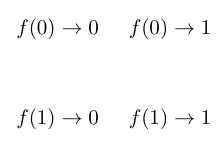

Based on these possibilities, we can say that f is guaranteed to be either a ’balanced’ or ’constant’ function. 

A balanced function
means that f ’s outputs will be half 0’s and half 1’s, ex: f (0) → 1, f (1) → 0. A constant function means that the output will
be either all 0’s or all 1’s, ex: f (0) → 1, f (1) → 1. So then, given this mysterious f , what is the minimum number of uses
by which we can determine whether it is a balanced or constant function?

Well, let’s take a look at the classical approach. Since we can only work with classical bits, let’s say we feed the function a 0,
and we get back a 1. We now have one piece of information: f (0) → 1. But based on this one result, can we conclude what will
happen for f (1)?

The answer is no. The information we got from one call of the function f is insufficient to determine whether f is a balanced or
constant function. If we get f (1) → 1, we will conclude that f is constant, while if we get f (1) → 0, we will conclude that
it is balanced. Thus, classically, we use the black box function f twice in order to determine its nature. If you are still a little
unsure, the diagram below represents a flow chart of all the possibilities:

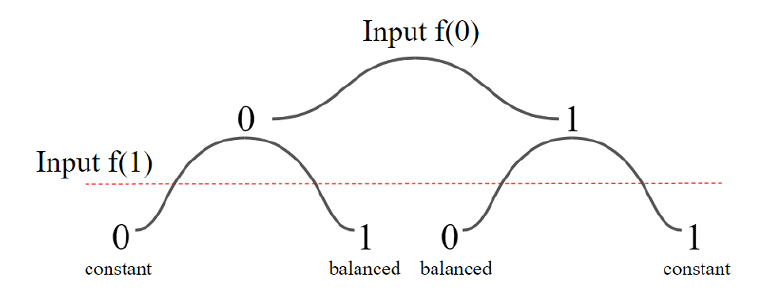

Let’s write up a simple code to simulate this problem:

In [99]:
import math as m
import scipy as sci

def blackbox():
  '''
  Returns one of the four possible functions
  '''
  def F1(x):
    return 0

  def F2(x):
    return 1

  def F3(x):
    return x%2

  def F4(x):
    return (x+1)%2

  functions = [F1,F2,F3,F4]
  f = functions[int(m.floor(4*sci.rand()))]
  return f


In [100]:
F = blackbox()

print('Output for f(0): ', F(0))
print('Output for f(1): ', F(1))

if(F(0) == F(1)):
  print('Conclusion: The function f in blackbox is a constant function')
else:
  print('Conclusion: The function f in blackbox is a balanced function')

Output for f(0):  1
Output for f(1):  1
Conclusion: The function f in blackbox is a constant function


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.rand is deprecated and will be removed in SciPy 2.0.0, use numpy.random.rand instead


The cell of code above randomly generates one of the four possible black box functions, tests it with the inputs f (0) and f (1),
and concludes whether the function is balanced or constant based on the results. It’s kind of a silly example, but it gets the point
across.

Now, let’s see if we can do any better with our powerful quantum computers! As you might imagine, there’s really only one way
to be faster than the classical approach here. We need to be able to determine if f is constant or balanced in only one function call.

When we move out of the realm of classical computing, and into quantum computing, what we gain are qubits over bits. Thus,
we are going to give the function f a qubit as an input. However, **we assume that f is a classical function**, meaning that **we can’t
actually feed it a qubit in the same way we can feed it a regular bit**. There’s a couple valid reasons why f shouldn’t be able to
handle a qubit, but the best is perhaps a simple mathematical argument. 

Consider what would happen if we sent in a qubit in a
superposition state between |0i and |1i, for a constant f :

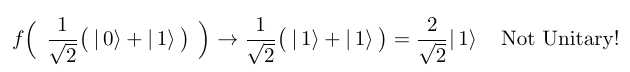

Remember that quantum systems always must be unitary (it’s not our rule, blame physics!). Thus, f is a strictly classical
function that only operates on classical bits.

So then, in order to use a quantum computer, we must side-step the problem of using f . To do this, we will define a quantum
operation g, which will incorporate our classical function f in such a way that we still have a unitary operator. For the same
reason shown above, there’s just no way of creating a unitary operator that incorporates f and acts on 1 qubit. Thus, the best we
can do is an operator that acts on two qubits:

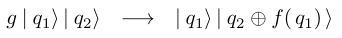

where the symbol ⊕ means addition modulo 2: 0 ⊕ 1 = 1, 1 ⊕ 1 = 0 (basically if a number adds up to 2, it becomes a 0).

Let’s see a quick example for a function f ( 0, 1) → ( 0, 1):

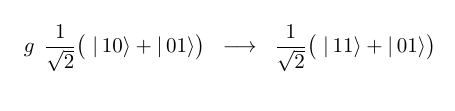

More specifically:

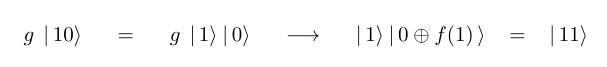

Now, you may be wondering where the heck this addition modulo 2 came from. This is part of the trick that comes with solving
classical problems via quantum algorithms. Sometimes we need to introduce new ways of approaching the problem. Here, **we
are able to incorporate f into our quantum operation by using ⊕, which will guarantee everything stays unitary.**

Most importantly however, by using this g, we can see that based on what kind of function f is, we get different final states:

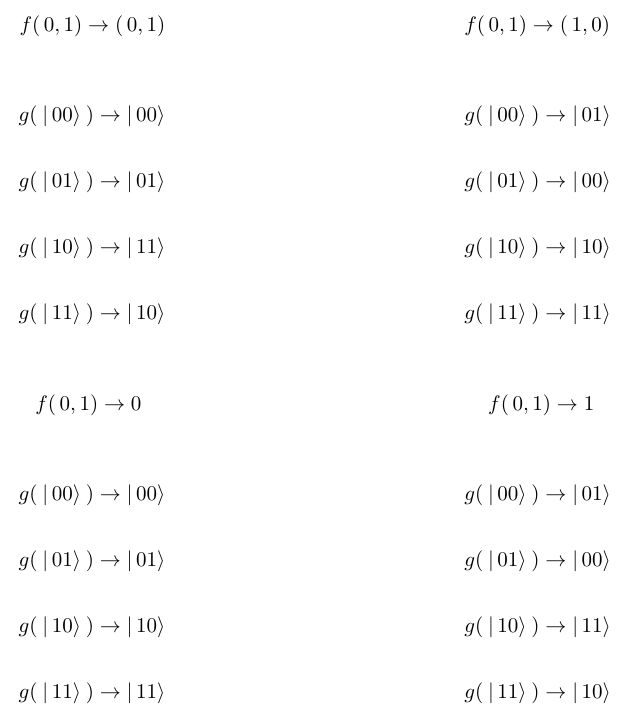

Just like how our classical f can map the bits (0,1) to one of four possibilities, our g operator can map our two qubit states to
one of four final states. Also like the classical case, if we use only one state as an input, we cannot determine whether f is a
balanced or constant function. For example, using the state |00i as an input will give us one of two results: |00i or |01i. Based
on which result we get, we’ve eliminated two out of the four categories above, but still are left with with two possibilities, one
balanced and one constant.

Now that we have our g function mathematically defined, it’s time to create it in our code.

In [101]:
def Blackbox_g_D(qc,qreg):
  '''
  Generates a random blackbox unitary operator g, based on a balanced or constant f
  '''
  f_type = ['f(0,1)-> (0,1)', 'f(0,1) -> (1,0)', 'f(0,1) -> 0', 'f(0,1) -> 1']

  r = int( m.floor( 4*sci.rand()))

  if(r==0):

    qc.cx( qreg[0], qreg[1])

  if(r==1):

    qc.x( qreg[0])

    qc.cx(qreg[0], qreg[1] )

    qc.x( qreg[0])

  if(r==2):

    qc.id( qreg[0] )

    qc.id( qreg[1])

  if(r==3):

    qc.x( qreg[1])

  return f_type[r]

In [106]:
q = QuantumRegister(2, name='q')

test_g =  QuantumCircuit(q, name='qc')

test_g.h( q[0] )

test_g.x( q[1] ) 

test_g.cz( q[0], q[1] ) 

test_g.x( q[1] )


print('_ Initial State ___:', execute(test_g,S_simulator).result().get_statevector() ) 
Wavefunction(test_g)

f = Blackbox_g_D(test_g,q)

print('\n __After Blackbox _____:', execute(test_g,S_simulator).result().get_statevector() ) 
Wavefunction(test_g)


_ Initial State ___: Statevector([ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,
              0.        +0.j],
            dims=(2, 2))
0.70711 |00>     -0.70711 |10>     

 __After Blackbox _____: Statevector([ 0.        +0.j,  0.        +0.j,  0.70710678+0.j,
             -0.70710678+0.j],
            dims=(2, 2))
0.70711 |01>     -0.70711 |11>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:7: Deprecation

As mentioned before, if we want to to do better than the classical case, we need to be able to determine whether f is constant or
balanced, with only one call of g. As shown above, using only one state as an input does not get the job done. So then, we will
send in a superposition of states, since that is the big advantage to using qubits over bits!

Now, let’s use the state in our code example to demonstrate what we can do with our final state, say for the case f (0, 1) → (1, 0):

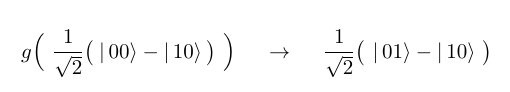

Compare the result we have here, with the four possibilities above. By sending in this superposition state, our output states
corresponds to exactly one of the possible f ’s (we did it!). Thus, if we could read out the entire final state, we would be done.
But alas, we can’t see wavefunctions, only measurements:

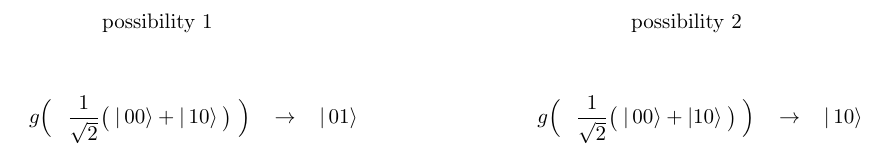

Two things are problematic here: 
1. Individually, neither measurement result is conclusive as to what kind of function f is. 
2. 
Even if one of the measurements could tell us about f , there’s only a 50% chance we get that measurement result.

Never fear, for there is a correct input state still to come. This example was just meant to demonstrate the potential that qubits
and superposition states have to offer. The trick is that we need to be thinking of what kind of final wavefunction we will get
and the information we can extract from a measurement on that state. So, without further ado, let’s take a look at the input state
that is going to solve our problem:

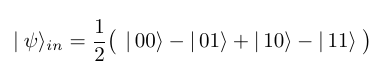

Which is obtainable by the following sequence of gates:

In [109]:
q = QuantumRegister(2, name='q') 
deutsch_qc = QuantumCircuit(q, name="qc")

deutsch_qc.h( q[0] ) 
deutsch_qc.x( q[1] ) 
deutsch_qc.h( q[1] )

print('_ State ___:', execute(deutsch_qc,S_simulator).result().get_statevector() ) 
Wavefunction(deutsch_qc)


_ State ___: Statevector([ 0.5+0.000000e+00j,  0.5+0.000000e+00j, -0.5-6.123234e-17j,
             -0.5-6.123234e-17j],
            dims=(2, 2))
0.5 |00>     0.5 |10>     -0.5 |01>     -0.5 |11>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


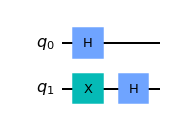

In [110]:
deutsch_qc.draw('mpl')

Alright, let’s see what happens when we apply our gate g to this input state:

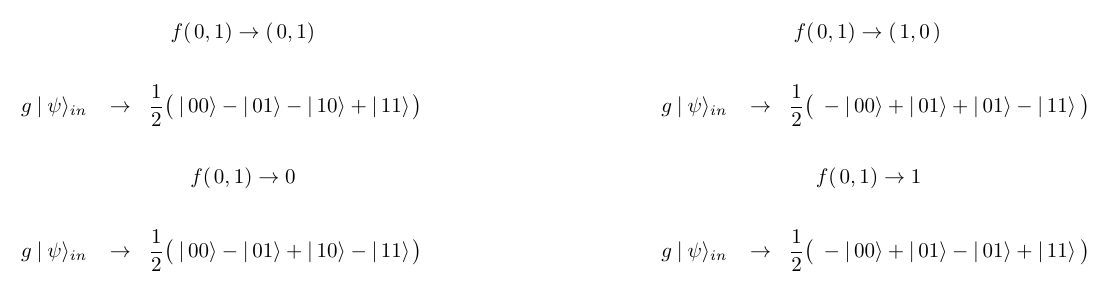

Now, based on the four results above, we can start to see an interesting result emerging: the output states for both cases where f
is balanced are equal, up to a phase difference. And the same holds true for both output states when f is constant. However, as
we noted before, we can only see this when looking at the wavefunctions, but a measurement result will not give us this same
information. In fact, all four states will produce the same measurement probabilities.

Sooo, let’s do one more thing: apply Hadamard gates to both qubits. Now, I will setup the algebra below, but skip most of the
steps. I encourage you to go through one of the calculations for yourself. If you plan to follow along through the rest of the
lesson, I strongly recommend working through the algebra steps, as we will be using Hadamard transformations like
this one a lot:

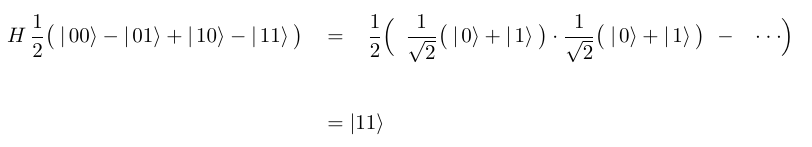

Doing all the algebra for the four possible f functions, we get the following final states:

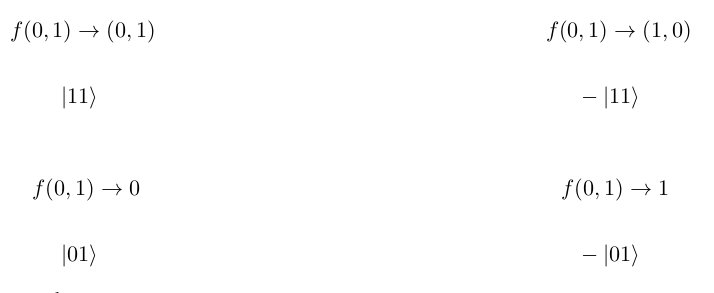

Let’s confirm this with our code:

In [114]:
q = QuantumRegister(2, name='q') 
deutsch_qc = QuantumCircuit(q, name='qc')

deutsch_qc.h( q[0] )

deutsch_qc.x( q[1] ) 

deutsch_qc.h( q[1] )

print('\n_ Initial State ___:', execute(deutsch_qc,S_simulator).result().get_statevector() ) 
Wavefunction(deutsch_qc)

f = Blackbox_g_D(deutsch_qc,q)

print('\n__ State After Blackbox ___:', execute(deutsch_qc,S_simulator).result().get_statevector() ) 
Wavefunction(deutsch_qc)

deutsch_qc.h( q[0]) 

deutsch_qc.h( q[1])

print('\n_ After Applying H^2 State ___:', execute(deutsch_qc,S_simulator).result().get_statevector() ) 
Wavefunction(deutsch_qc)


_ Initial State ___: Statevector([ 0.5+0.000000e+00j,  0.5+0.000000e+00j, -0.5-6.123234e-17j,
             -0.5-6.123234e-17j],
            dims=(2, 2))
0.5 |00>     0.5 |10>     -0.5 |01>     -0.5 |11>     

__ State After Blackbox ___: Statevector([ 0.5+0.000000e+00j, -0.5-6.123234e-17j, -0.5-6.123234e-17j,
              0.5+0.000000e+00j],
            dims=(2, 2))
0.5 |00>     -0.5 |10>     -0.5 |01>     0.5 |11>     

_ After Applying H^2 State ___: Statevector([7.85046229e-17-6.123234e-17j, 1.11022302e-16+6.123234e-17j,
             1.57009246e-16+6.123234e-17j, 1.00000000e+00-6.123234e-17j],
            dims=(2, 2))
1.0 |11>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:7: Deprecation

So then, how do we extract our information from these finals states is the final question. If we take a look at all four possibilities,
we can see that qubit 1 is always in the |1⟩ state, so that’s no good to us. However, **when we make a measurement on qubit 0, we
will get one of two possibilities. If we measure a |1⟩, we can conclude that f is a balanced function, and if we measure a |0⟩
can conclude that f is constant.** Thus, we have successfully identified what kind of function f is, with **only one function call!**

We have now completed the Deutsch Algorithm, in all its glory. In order to determine if a black box function f is constant or
balanced, we do the following:

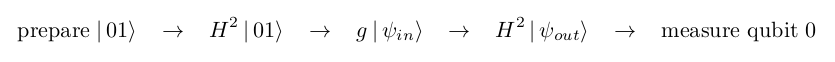

And as shown above, the measurement result on qubit 0 will perfectly determine f ’s nature for us. In fact, since we never bother
to check qubit 1, we can actually get the same results by only applying a single Hadamard gate on qubit 0, after g. This will
result in qubit 0 becoming either |0⟩ or |1⟩, while leaving qubit 1 still in a superposition. This is just a slight optimization.

Since the steps to solving the Deutsch Algorithm are always the same, we can create a function that will always apply the steps
for us.

In [115]:
def Deutsch(qc,qreg):
  '''
  Apply the Deutsch Algorithm to a QuantumCircuit
  '''
  
  qc.h( qreg[0] )
  qc.h( qreg[1] )

  f = Blackbox_g_D(qc,qreg)

  qc.h( qreg[0] )
  qc.h( qreg[1] )

  return f


Lets see the code running with an example:

In [117]:
q = QuantumRegister(2, name='q')

c = ClassicalRegister(2, name='c')

deutsch_qc = QuantumCircuit (q, c, name='qc')

deutsch_qc.id( q[0] )

deutsch_qc.x( q[1] )

f = Deutsch(deutsch_qc,q)

deutsch_qc.measure(q,c)

Qubit0_M = list(execute(deutsch_qc, M_simulator, shots=1).result().get_counts(deutsch_qc).keys())[0][1]

if(Qubit0_M=='0'):

  print('Measured state |0> therefore f is constant!')

else:

  print('Measured state |1> therefore f is balanced!')

print('')

print(' hidden f: ', f)

Measured state |1> therefore f is balanced!

 hidden f:  f(0,1) -> (1,0)


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.rand is deprecated and will be removed in SciPy 2.0.0, use numpy.random.rand instead
  import sys


Running this cell of code a couple times should convince you that we have indeed solved our blackbox f problem using the
Deutsch Algorithm. Our conclusion about f is always 100% correct, and we can even check the f function to prove it!

# **Further Analysis of the Deutsch Algorithm**
***

The last code example is the full Deutsch Algorithm, but our work isn’t finished yet. In Deutsch-Jozsa & Bernstein-Vazirani Algorithms, we are
going to be encountering similar tricks over and over, and they’re all related to the Hadamard gate. Specifically, the ’Hadamard
Transformation’, which just means we apply H gates to all of the qubits in the system. In this final section, we are going to
cover why this transformation works, and also briefly on how we constructed our blackbox g operator.

## **The Hadamard Transformation**

Now, if you followed through with the algebra steps we left out previously, then you may have noticed the underlying pattern.
To begin, let’s imagine for a second that we exclude the g step of our algorithm. Following our state’s wavefunction through
each step, we get:

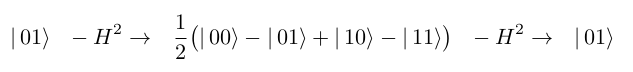

Now, if f happens to be constant, this is essentially the whole process. The effect of g will either leave the state completely
unchanged (f → 0), or apply an overall phase -1 (f → 1). Thus, in both cases we can see that the second H 2 operation maps
us back to either |01⟩ or −|01⟩. Note how two applications of $H^2$ takes us back to our original state.

By contrast, if f is balanced, the net effect of g appears in the form of moving the two negative signs around. Or more specifically,
moving the negative signs onto a different pair of states:

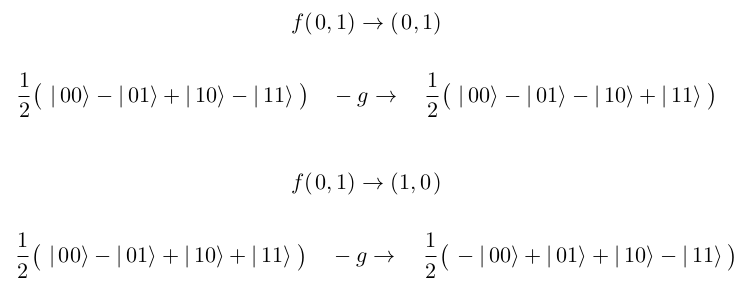

For the top example, we can see that the states |10⟩ and |11⟩ switch amplitudes. And for the second case, we have states |00⟩
and |01⟩ switch. The net effect is that in both balanced cases the states |00⟩ & |11⟩ always have the same sign, as well as |01⟩ &
|10⟩. By contrast, for both constant cases, our ’paired’ states that always have the same sign are |00⟩ & |10⟩ , and |01⟩ & |11⟩.
Keep this in mind, as next we are going to show the full Hadamard transformation map on two qubits:

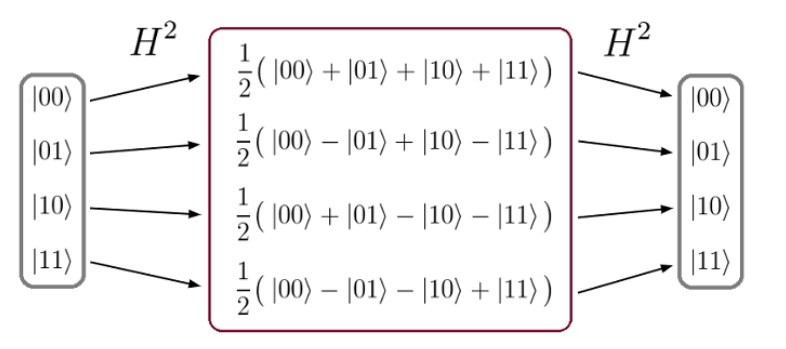

As shown above, the Hadamard Transformation maps each of the four possible two qubit states to a unique superposition state,
AND, all of these states are orthogonal (easy to check for yourself). So then, take a look at the mapping above, and compare it
to the effect of g we pointed out earlier. You should find that the final states we obtain after g correspond to the ones that map
back to |01⟩ for a constant f , and |11⟩ for a balanced f .

Now that we’ve seen how the $H^2$ transformation works, let’s take a look at the steps of our algorithm again. Run the cell of code
below a few times, and confirm for yourself that g always puts our state in one of the superposition states that will get mapped
to either |01⟩ or |11⟩ (and don’t forget about an overall phase of -1):

In [119]:
q = QuantumRegister(2, name='q') 

deutsch_qc = QuantumCircuit(q, name='qc')

deutsch_qc.h( q[0] )

deutsch_qc.x( q[1] )

deutsch_qc.h( q[1] )

print(' Initial State',  execute(deutsch_qc,S_simulator).result().get_statevector() )
Wavefunction(deutsch_qc)

f = Blackbox_g_D(deutsch_qc,q)

print(f)

print('\n After Blackbox', execute(deutsch_qc,S_simulator).result().get_statevector() )
Wavefunction(deutsch_qc)

deutsch_qc.h( q[0])

deutsch_qc.h( q[1] )

print('\n After H^2',   execute(deutsch_qc,S_simulator).result().get_statevector() )
Wavefunction(deutsch_qc)

 Initial State Statevector([ 0.5+0.000000e+00j,  0.5+0.000000e+00j, -0.5-6.123234e-17j,
             -0.5-6.123234e-17j],
            dims=(2, 2))
0.5 |00>     0.5 |10>     -0.5 |01>     -0.5 |11>     
f(0,1) -> (1,0)

 After Blackbox Statevector([-0.5-6.123234e-17j,  0.5+0.000000e+00j,  0.5+0.000000e+00j,
             -0.5-6.123234e-17j],
            dims=(2, 2))
-0.5 |00>     0.5 |10>     0.5 |01>     -0.5 |11>     

 After H^2 Statevector([ 7.85046229e-17-6.1232340e-17j,
             -1.11022302e-16-6.1232340e-17j,
              1.57009246e-16-6.1232340e-17j,
             -1.00000000e+00-1.8369702e-16j],
            dims=(2, 2))
-1.0 |11>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:7: Deprecation

## **Constructing g**

In this final section, we will briefly cover how we constructed the blackbox function g, as it is also insightful into the thought
process behind constructing quantum operations from a gate level perspective. To begin, let’s see the four possible g operators
in matrix form, followed by their gate instructions:

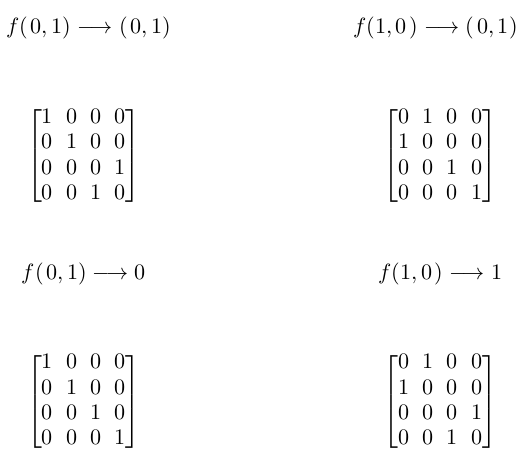

where these matrices are operating on the basis:

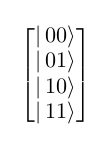

Take a look at these four matrices and see if you recognize any of them (hint: two of them are gates we studied in class lectures).

For starters, the matrix corresponding to f (0, 1) → 0 is just the Identity matrix on two qubits: $I^2$ . And also, the matrix
corresponding to f (0, 1) → (0, 1) is just a CNOT gate! Scroll all the way back up to where we first outlined the full effect of g
on each possible input state, and confirm for yourself that the operations that describe f (0, 1) → 0 and f (0, 1) → (0, 1) are
indeed just $I^2$ and CNOT.

Now, the case for f (0, 1) → 0 is the easiest to understand. Since everything maps to 0, and our g operator is addition modulo
2: | q1 ⊕ 0i , every state remains unchanged. For the remaining other three matrices, they are all categorizable by a single
pattern: which inputs get mapped to 1. Specifically, if either 0 or 1 gets mapped to 1, we find a corresponding 2x2 matrix located along the diagonal:$\begin{bmatrix} 0 & 1 \\ 1 & 0 \ \end{bmatrix}$. And conversely, if a particular input gets mapped to 0, we find a: $\begin{bmatrix} 1 & 0 \\ 0 & 1 \ \end{bmatrix}$. Both of thesematrices should be recognizable, as they are just the X and I single qubit gates.

So what is this telling us about g? Well, we are now seeing why we chose to incorporate f into our g operator via ⊕ (addition
modulo 2). Loosely speaking, adding ⊕ 1 to a qubit state is equivalent to applying an X, and adding ⊕ 0 is equivalent to doing
nothing (which is what an I gate does). But remember that g only affects our second qubit, which means none of these matrices
should ever change the state of qubit 0. Or another way of saying that is, the only transformations that are allowed are: |00⟩ ↔
|01⟩ and |10⟩ ↔ |11⟩.

So then, how can we deduce what g will look like, based on which inputs map to 0 and 1? Well, for the balanced cases where
the input get mapped to one of each output, ask yourself what kind of gate operation flips the states on one qubit, contingent on
on the state of the other qubit. That’s a CNOT! And for the constant case f (0, 1) → 1 , what kind of gate operation flips the
states on a particular qubit, regardless of all other qubit states. An X gate!

Starting with the f (0, 1) → 1 case, you may be looking at the matrix representation above and thinking, ”that doesn’t look
like a regular X gate”. True, because it’s a single qubit X gate applied to a 2-qubit system. Remember, g needs to operate on the whole system, so all matrix representations must be 4×4. Thus, to see what a single qubit operation looks like on a 2-qubit
system, we need to take the tensor product: I ⊗ X. This operation leaves qubit 0 unchanged thanks to the Identity gate, and
applies our X gate to qubit 1. If you’re new to ’outer product’ matrix multiplication, here’s a step-by-step walk through:

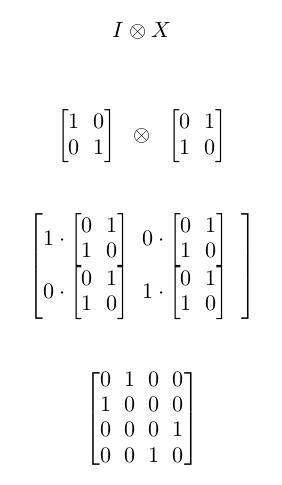

Luckily, matrix representations are not a necessary ingredient for creating quantum algorithms, only gates (although sometimes
matrix representations are very insightful). Thus, when we go to write our code, we need only use a single X gate on qubit 1,
and not I ⊗ X.

We are now officially done with Deutsch Algorithm! Although it’s just a one-step process, the Deutsch Algorithm is an
important first hurdle in terms of understanding how quantum algorithms can outperform classical counterparts, and the subtle
math tricks involved. As you’ve probably already guessed, there’s a lot that goes into even the simplest of quantum algorithms!
But have no fear, many of the topics covered in this lab will be seen again in future algorithms.